In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os

In [2]:
path = 'E:\\Data_Science\\OpenClassRoom\\Projet 5\\archive'
cust_df=pd.read_csv(path + '\\olist_customers_dataset.csv')
geo_df=pd.read_csv(path +'\\olist_geolocation_dataset.csv')
ord_it_df=pd.read_csv(path + '\\olist_order_items_dataset.csv')
ord_pay_df=pd.read_csv(path + '\\olist_order_payments_dataset.csv')
ord_rev_df=pd.read_csv(path + '\\olist_order_reviews_dataset.csv')
ord_df=pd.read_csv(path + '\\olist_orders_dataset.csv')
prod_df=pd.read_csv(path + '\\olist_products_dataset.csv')
sell_df=pd.read_csv(path + '\\olist_sellers_dataset.csv')

In [3]:
dfs = {0:cust_df,1:geo_df,2:ord_it_df,3:ord_pay_df,4:ord_rev_df,5:ord_df,6:prod_df,7:sell_df}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

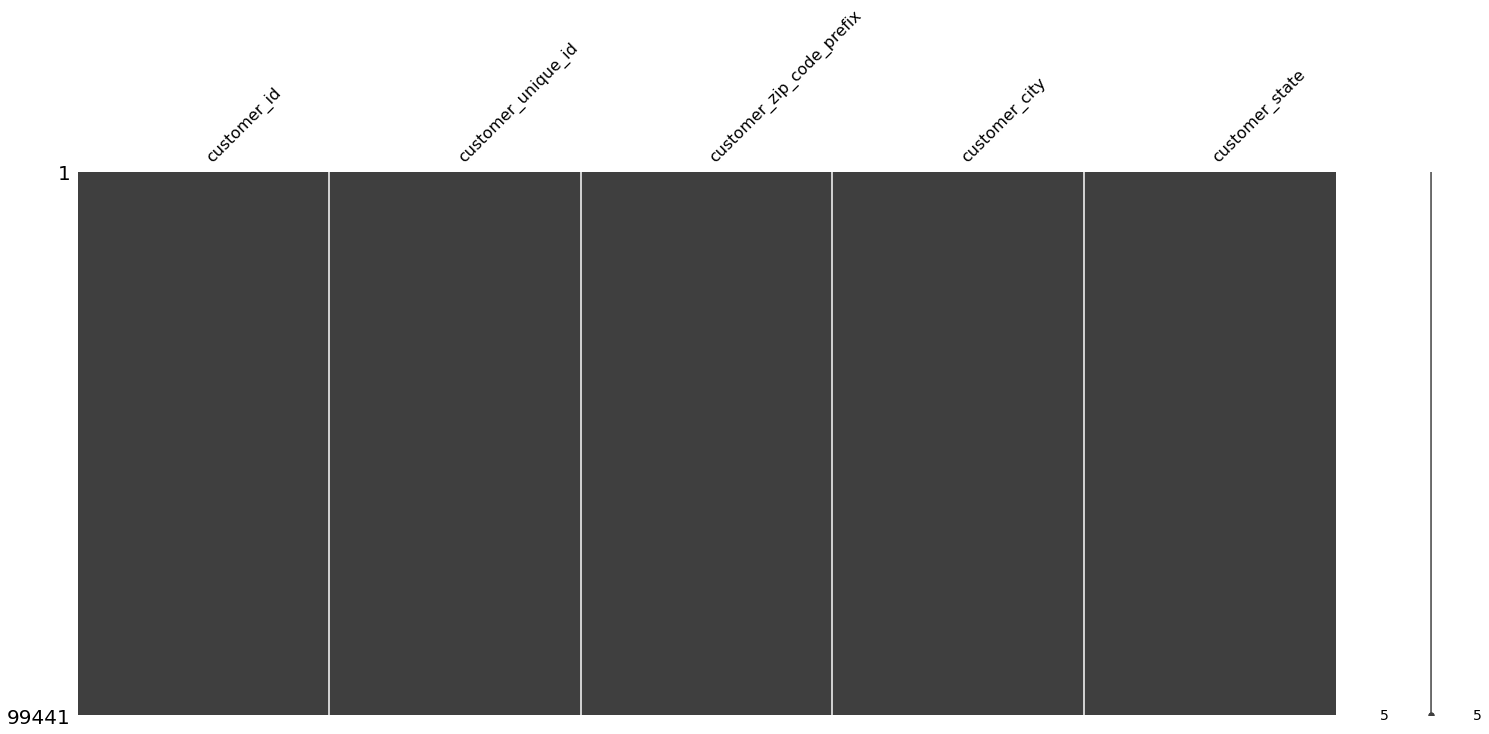

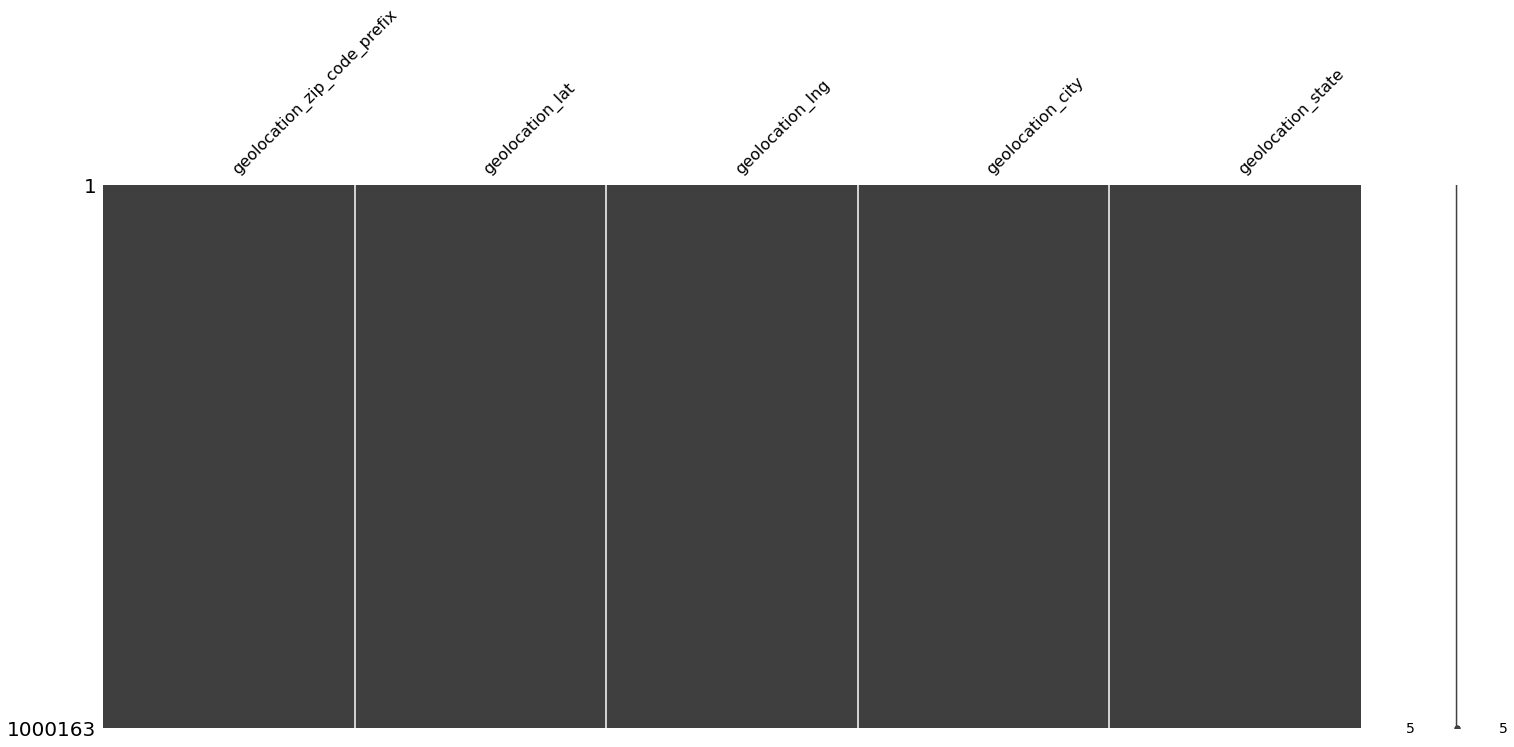

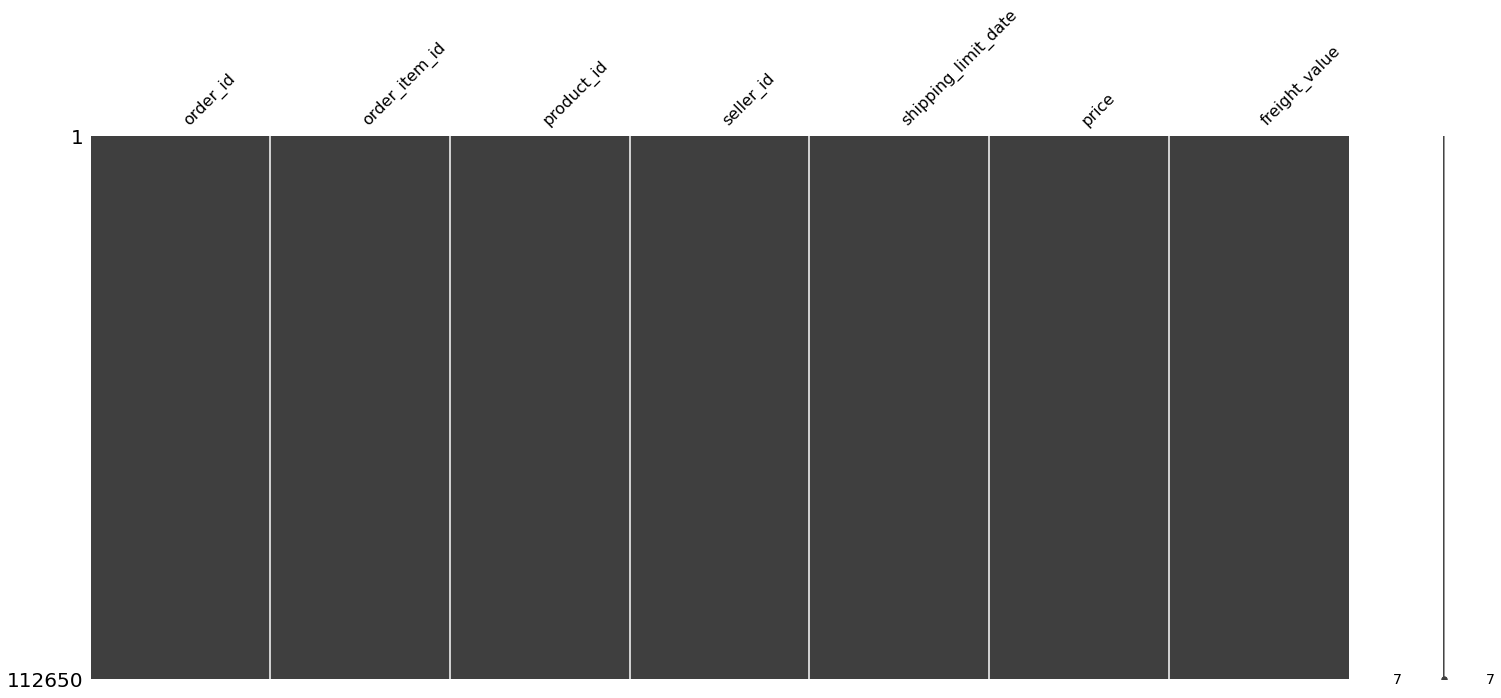

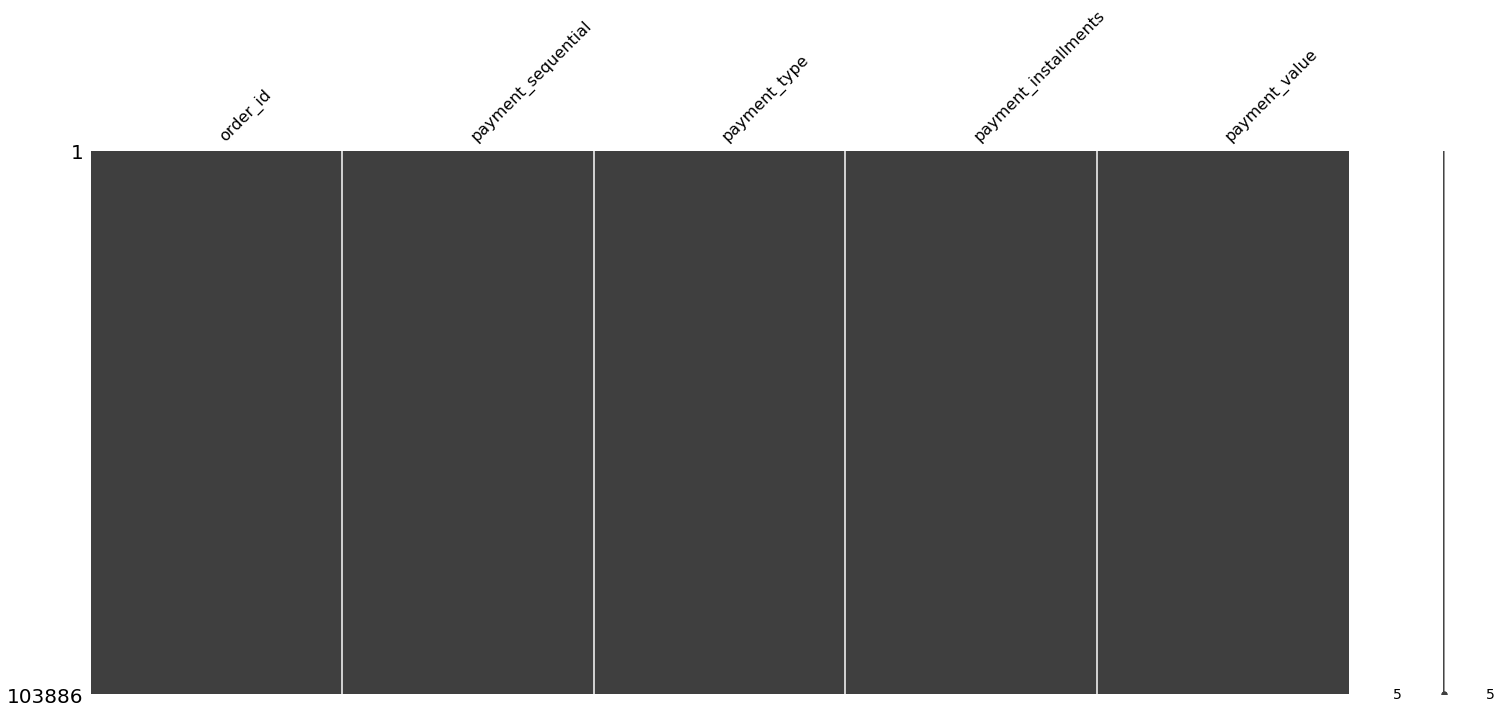

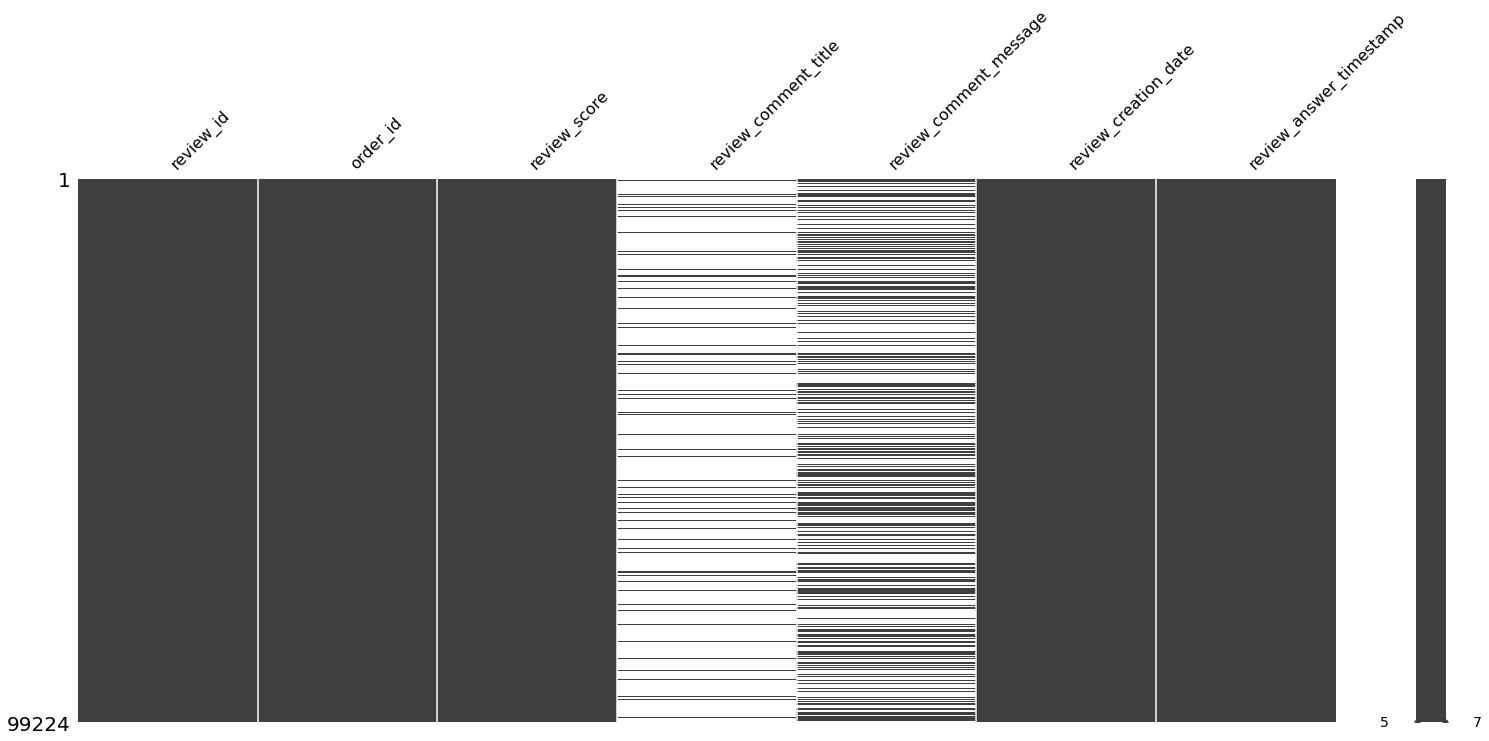

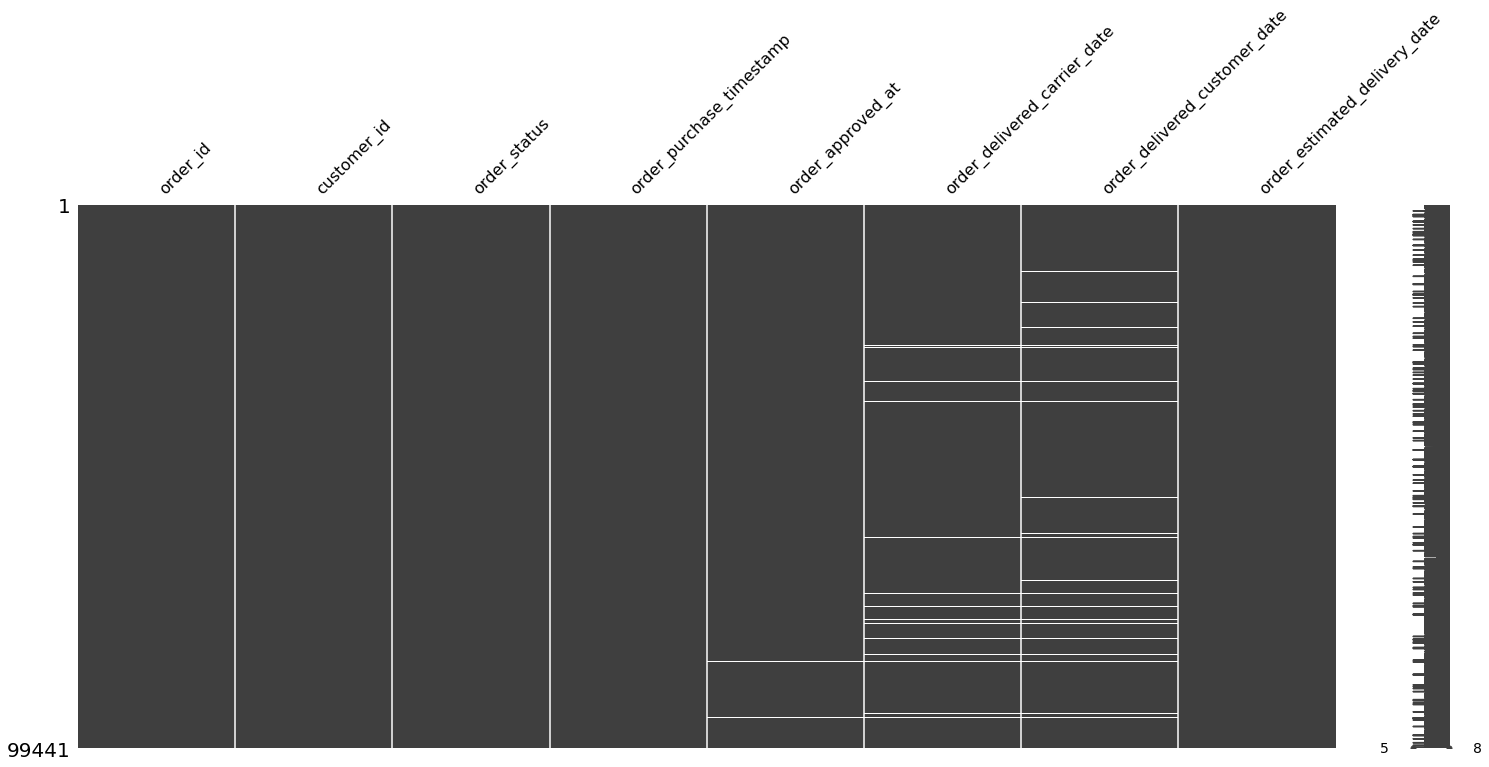

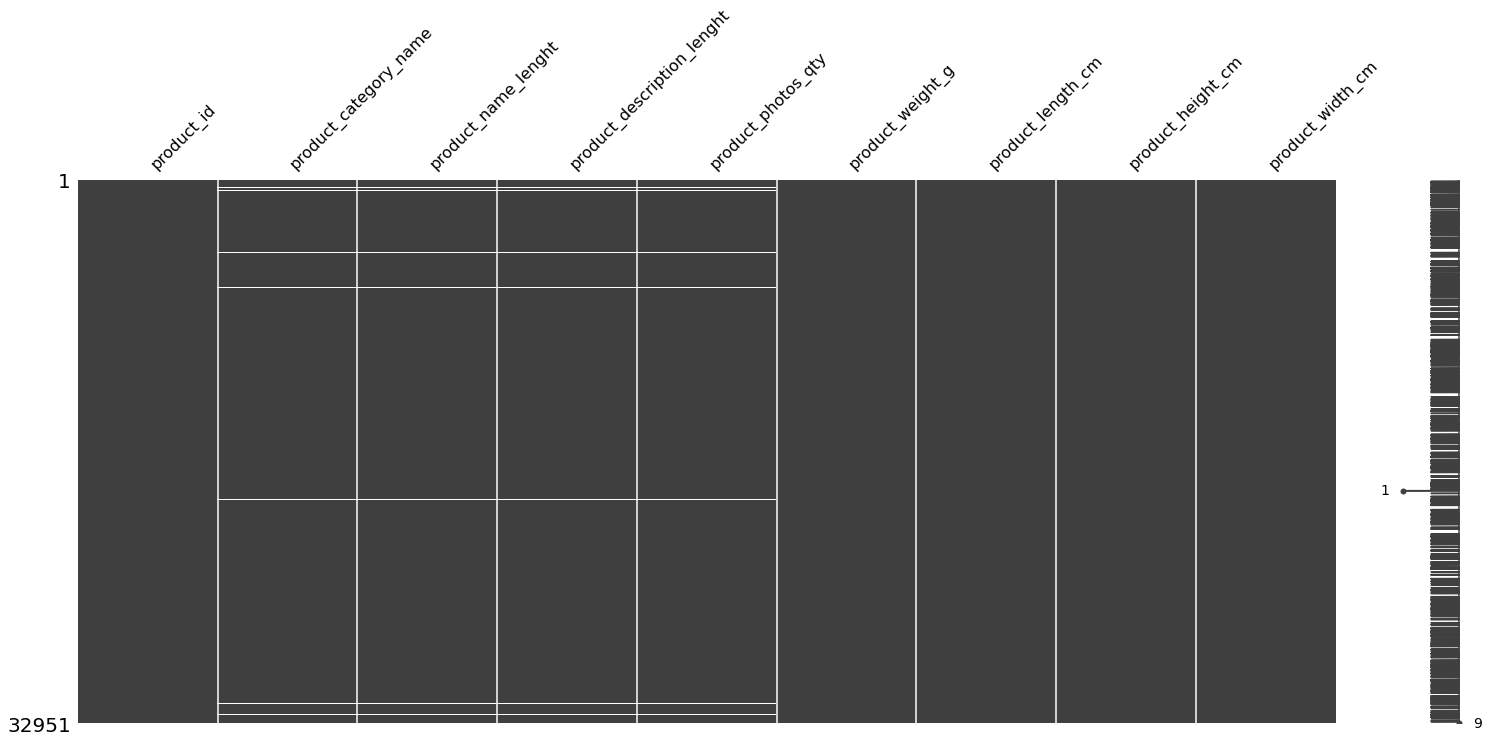

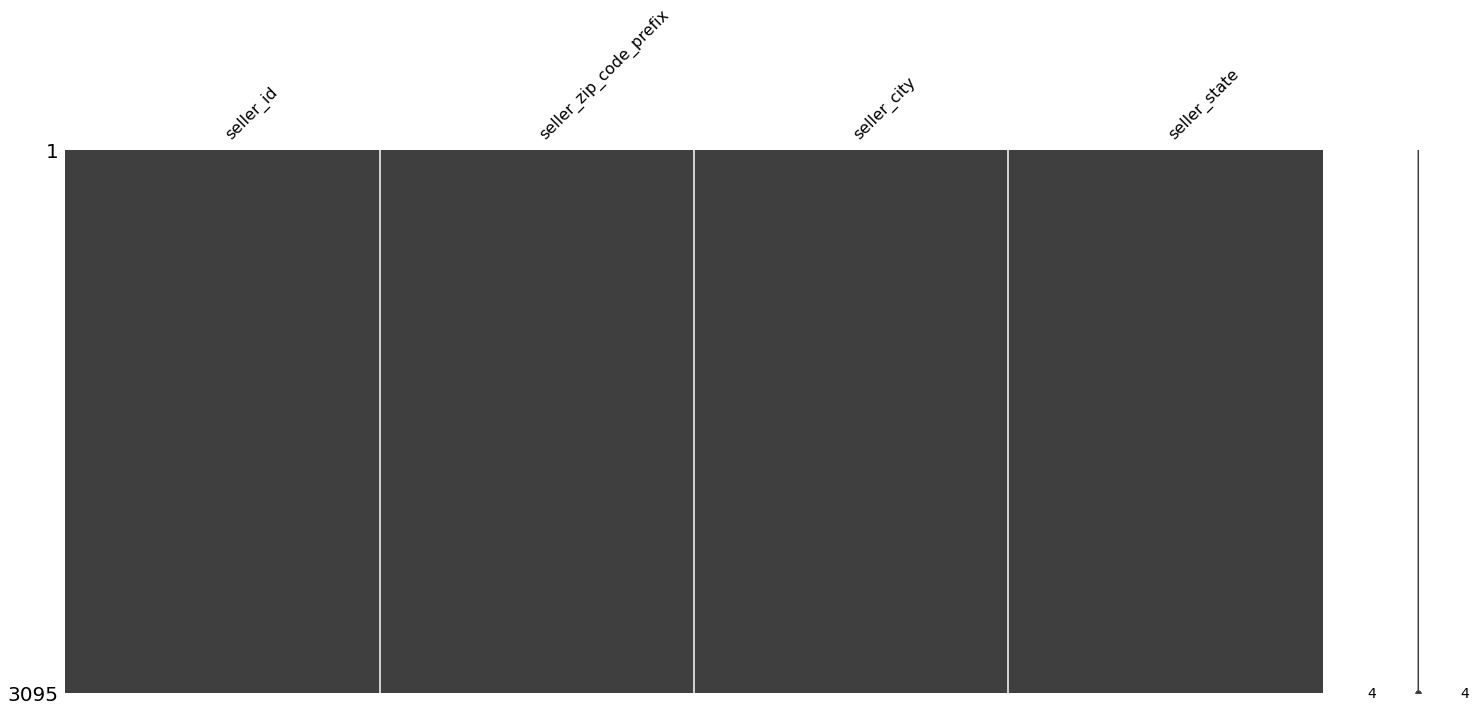

In [4]:
for i in dfs:
    print(dfs[i].info())
    msno.matrix(dfs[i])

In [5]:
#get the customers that ordered more than once
multi_cust_df = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]

#get their customer_id
multi_custom = multi_cust_df[['customer_id','customer_unique_id']]
multi_id = multi_custom['customer_id']
multi_uni_id = multi_custom['customer_unique_id']
#get their order_id
multi_order_df = dfs[5][dfs[5]['customer_id'].isin(multi_id)]
multi_order_id = multi_order_df['order_id']

multi_pay_df = dfs[3][dfs[3]['order_id'].isin(multi_order_id)]
#get their review score
multi_rev_df = dfs[4][dfs[4]['order_id'].isin(multi_order_id)]

#get the category of each order
multi_prod_df =  dfs[2][dfs[2]['order_id'].isin(multi_order_id)]
multi_prod_id = multi_prod_df['product_id']
multi_cat_df = dfs[6][dfs[6]['product_id'].isin(multi_prod_id)].set_index('product_id')

cat_ser = multi_cat_df['product_category_name']
multi_prod_df = multi_prod_df.join(cat_ser, on = 'product_id')
multi_prod_df = multi_prod_df.dropna(subset = 'product_category_name') #74 product don't have a category name


In [6]:
multi_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7469 entries, 1 to 112630
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               7469 non-null   object 
 1   order_item_id          7469 non-null   int64  
 2   product_id             7469 non-null   object 
 3   seller_id              7469 non-null   object 
 4   shipping_limit_date    7469 non-null   object 
 5   price                  7469 non-null   float64
 6   freight_value          7469 non-null   float64
 7   product_category_name  7469 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 525.2+ KB


In [7]:
def cat_name(x):
    temp = set()
    for i in x:
        if i not in temp:
            temp.add(i)
    temp = str(temp)
    return temp

In [8]:
multi_cat_df['product_category_name'].unique().shape

(71,)

In [9]:
x = dfs[0]['customer_id'].unique().shape[0]
y = dfs[0]['customer_unique_id'].unique().shape[0]
print(x,y, 1-(y/x))

99441 96096 0.033638036624732304


In [10]:
import time
import datetime

def days(x):
    td = time.time()
    t = time.mktime(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S").timetuple())
    d = int((td - t)/86400)
    return d

In [11]:
##build the working df of each order
#take the customer id
df = pd.DataFrame(multi_custom)
df = df.set_index('customer_id')
df = df.join(multi_order_df[['customer_id','order_id', 'order_purchase_timestamp']].set_index('customer_id'))
#take the value of each order
temp = pd.DataFrame()
temp['order_total'] = multi_pay_df.groupby('order_id').payment_value.sum() #some order have voucher
df = df.join(temp, on = 'order_id')
#calculate the days since order of each order
df['days_since_order'] = df['order_purchase_timestamp'].apply(days)
#take the review score for each order
temp = pd.DataFrame(index = multi_rev_df.index)
temp['review_days'] = multi_rev_df['review_creation_date'].apply(days)
temp = temp.join(multi_rev_df[['order_id', 'review_score']])
agg_fun = {'review_days' : ['min'], 'review_score' : ['mean']}
temp = temp.groupby('order_id').agg(agg_fun)
df = df.join(temp, on = 'order_id', how='right')
df = df.drop(df.columns[5], axis=1 ) 
df = df.rename(columns = {df.columns[5] : 'review_score'})

#take the product category of each order
temp = pd.DataFrame(multi_prod_df.groupby('order_id').product_category_name.agg(lambda x: tuple(x)))

def cat_name(x):  #some orders have mulitple items from the same category
    y = set()
    for i in x:
        if i not in y:
            y.add(i)
    y = str(y)
    return y

temp['product_category_name'] = temp.applymap(cat_name)
df = df.join(temp, on = 'order_id')
df =df.dropna(subset = 'product_category_name')
df =  df[df.groupby('customer_unique_id').customer_unique_id.transform('count') > 1]#some customer didn't review all their orders
print(df.info(),df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 5929 entries, f6dd3ec061db4e3987629fe6b26e5cce to c5d108ecadaedf367e995520d36c9b1d
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        5929 non-null   object 
 1   order_id                  5929 non-null   object 
 2   order_purchase_timestamp  5929 non-null   object 
 3   order_total               5929 non-null   float64
 4   days_since_order          5929 non-null   int64  
 5   review_score              5929 non-null   float64
 6   product_category_name     5929 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 370.6+ KB
None                                                 customer_unique_id  \
customer_id                                                          
f6dd3ec061db4e3987629fe6b26e5cce  eb28e67c4c0b83846050ddfb8a35d051   
8085a9af46f619bc25966f151a362b0d  98758d88bf4b8eef1372ddee45d63178

E:\temp\ipykernel_43768\2430091187.py:18: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df = df.join(temp, on = 'order_id', how='right')


In [12]:
temp = pd.crosstab(df['customer_unique_id'], df['product_category_name'], values = df['product_category_name'], aggfunc= 'count', margins = True).fillna(0)

if (temp.iloc[-1,:] == 0.0).any():
    print('any')


In [13]:
#build the model df
md_df = pd.DataFrame(index = df['customer_unique_id'].unique())

#feature0  = number of order
md_df['n_order'] = df.groupby('customer_unique_id').order_id.count()

#feature1  = total value of orders
#md_df['payment_total'] = df.groupby('customer_unique_id').order_total.agg('sum')

#feature2-3  = mean and std of orders
md_df['payment_mean'] = df.groupby('customer_unique_id').order_total.agg('mean')
md_df['payment_std'] = df.groupby('customer_unique_id').order_total.agg('std')

#feature frequency4-10 of order on the distrib
df['order_dis'] = pd.cut(df['order_total'],10, duplicates = 'drop')
temp = pd.crosstab(df['customer_unique_id'], df['order_dis'], values = df['order_dis'], aggfunc= 'count', margins = True)
temp = temp.drop(labels = temp.columns[6:9], axis = 1) #there is 3 bucket with no orders
for i in range(temp.shape[1]):
    temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)

temp = temp.drop(labels = 'All')
temp = temp.drop(labels = 'All', axis = 1)
md_df = md_df.join(temp)
print(md_df.info())
#feature frequency11-135 of category
temp = pd.crosstab(df['customer_unique_id'], df['product_category_name'], values = df['product_category_name'], aggfunc= 'count', margins = True).fillna(0)
for i in range(temp.shape[1]):
    temp.iloc[:,i] = round((temp.iloc[:,i]/temp.iloc[:,-1])*100,2)
temp = temp.drop(labels = 'All')
temp = temp.drop(labels = 'All', axis = 1)
md_df = md_df.join(temp)
print(md_df.info())
#feature136-137 review score mean and std
md_df['rev_mean'] = df.groupby('customer_unique_id').review_score.agg('mean')
md_df['rev_std'] = df.groupby('customer_unique_id').review_score.agg('std')
#feature138  = days since last order
md_df['days_since_last_order'] = df.groupby('customer_unique_id').days_since_order.agg('min')
#feature139 = "age" of the custumer
md_df['age'] = df.groupby('customer_unique_id').days_since_order.agg('max')


print(md_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2808 entries, eb28e67c4c0b83846050ddfb8a35d051 to acc4424c209233de519e034152f30304
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   n_order               2808 non-null   int64  
 1   payment_mean          2808 non-null   float64
 2   payment_std           2808 non-null   float64
 3   (6.621, 505.438]      2808 non-null   float64
 4   (505.438, 999.316]    2808 non-null   float64
 5   (999.316, 1493.194]   2808 non-null   float64
 6   (1493.194, 1987.072]  2808 non-null   float64
 7   (1987.072, 2480.95]   2808 non-null   float64
 8   (2480.95, 2974.828]   2808 non-null   float64
 9   (4456.462, 4950.34]   2808 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 305.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2808 entries, eb28e67c4c0b83846050ddfb8a35d051 to acc4424c209233de519e034152f30304
Columns: 134 entries, n_order to {'utilid

<AxesSubplot:>

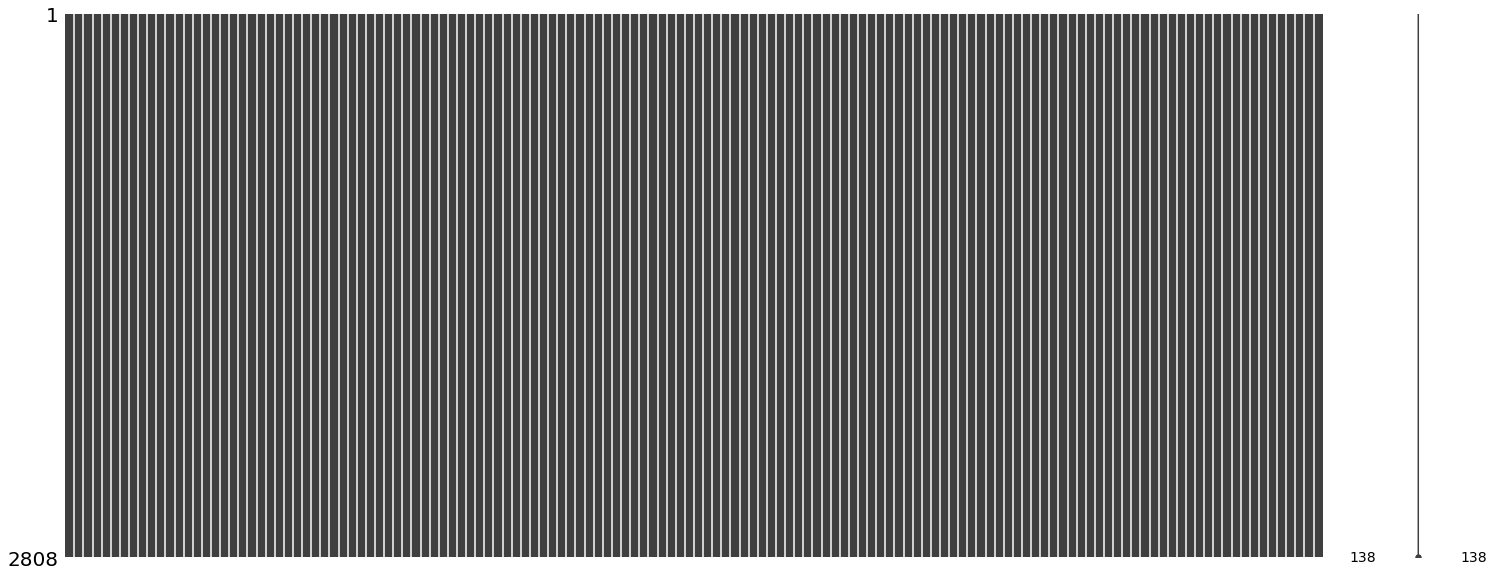

In [14]:
msno.matrix(md_df)

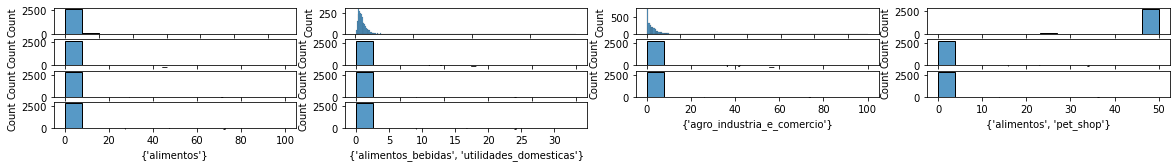

In [15]:
fig = plt.figure(figsize=(20,20))
for i in range(md_df.iloc[:,0:14].shape[1]):
    ax = fig.add_subplot(int((md_df.shape[1]/4)+1), 4, i+1)
    sns.histplot(md_df.iloc[:,i], ax = ax)

plt.show()

In [16]:
md_df.to_csv('md_df.csv', index = False)

## Dimention reduction

In [17]:
dim_df = pd.read_csv('md_df.csv')
#dim_df.iloc[:,11:136] = dim_df.iloc[:,11:136].apply(np.log)
x = dim_df.values
features = dim_df.columns

In [18]:
dim_df.isna().sum().sum()

0

In [19]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components = 2)
scaler = preprocessing.StandardScaler()
rscaler = preprocessing.RobustScaler()
mscaler = preprocessing.MinMaxScaler()

x_scale = rscaler.fit_transform(x)
#dim_df.iloc[:,11:136] = dim_df.iloc[:,11:136].apply(np.log)
pca.fit(x_scale)

PCA(n_components=2)

In [20]:
scree = (pca.explained_variance_ratio_*100).round(2).cumsum()
print(scree)

[13.66 24.09]


In [21]:
pd.DataFrame(pca.components_, columns = features, index = ['F1', 'F2'])



n_order  payment_mean  payment_std  (6.621, 505.438]  (505.438, 999.316]  \
F1  0.000120     -0.001611    -0.001247          0.025566           -0.016320   
F2  0.000609     -0.000692    -0.002738          0.031136           -0.022117   

    (999.316, 1493.194]  (1493.194, 1987.072]  (1987.072, 2480.95]  \
F1            -0.006477             -0.001062            -0.000581   
F2            -0.010192              0.000249            -0.000637   

    (2480.95, 2974.828]  (4456.462, 4950.34]  ...  \
F1            -0.000956            -0.000170  ...   
F2             0.001736            -0.000175  ...   

    {'tablets_impressao_imagem'}  {'telefonia'}  {'telefonia_fixa'}  \
F1                     -0.000393      -0.023413           -0.001303   
F2                     -0.000883      -0.018829            0.000659   

    {'utilidades_domesticas', 'market_place'}  \
F1                                  -0.000142   
F2                                  -0.000117   

    {'utilidades_domesticas', 'moveis_decoracao'}  {'utilidades_domesticas'}  \
F1                                       0.000474                  -0.020155   
F2                                      -0.000396                  -0.047406   

    rev_mean   rev_std  days_since_last_order       age  
F1 -0.001537 -0.000776               0.001406  0.000809  
F2  0.000749 -0.001326               0.001045  0.000759  

[2 rows x 138 columns]

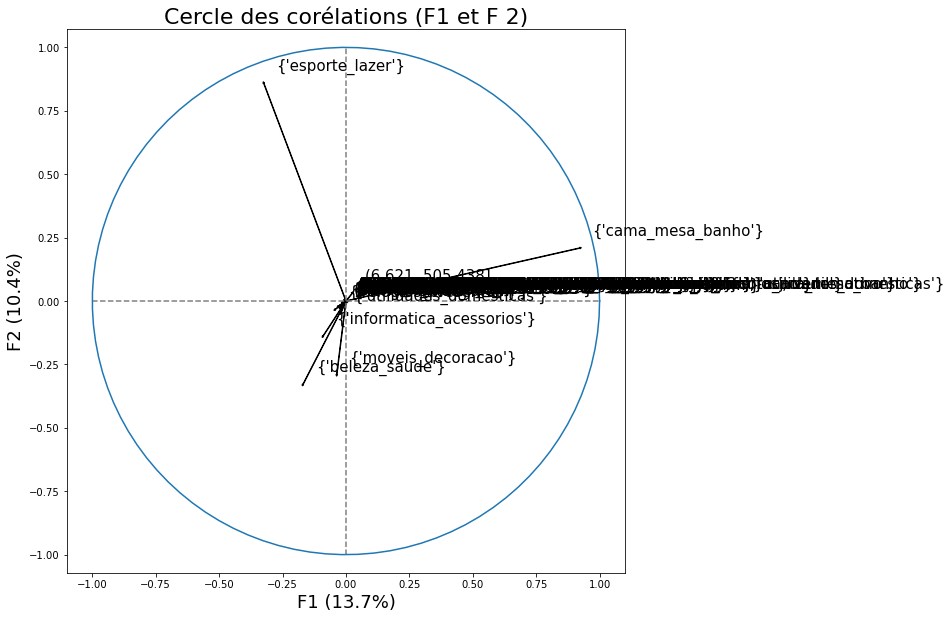

<Figure size 432x288 with 0 Axes>

In [22]:
x, y = 0,1 #define factorial space, (0,1) define the first factorial plane (F1, F2), (2,3) define the second (F3,F4) and so on(tuple)

fig, ax = plt.subplots(figsize = (10,10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,0, #start the arrow at the origin
                    pca.components_[0,i], #coordinate for PC1
                    pca.components_[1,i], #coordinate for PC2
                    head_width = 0.007,
                    head_length = 0.007,
                    width=0.002,) #graphical aspect of the arrow
    plt.text(pca.components_[0,i] + 0.05,
                        pca.components_[1,i] + 0.05,
                        features[i], fontsize = 15) # plot the text near each arrow head
plt.plot([-1,1], [0,0], color = 'grey', ls='--')
plt.plot([0,0], [-1,1], color='grey', ls='--') #plot the lines (abscissa and ordonate)

plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)), fontsize = 18) #label the axis with the percentage of explained variance
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)),fontsize = 18)

plt.title('Cercle des corélations (F{} et F {})'.format(x+1, y+1), fontsize = 22)

an = np.linspace(0, 2 * np.pi, 100) #return an np.array of the coordinates (100) of a circle of circonference 1 (2*pi)
plt.plot(np.cos(an), np.sin(an)) #plot the circle
plt.axis('equal') #set equal scaling
plt.show()
plt.clf()

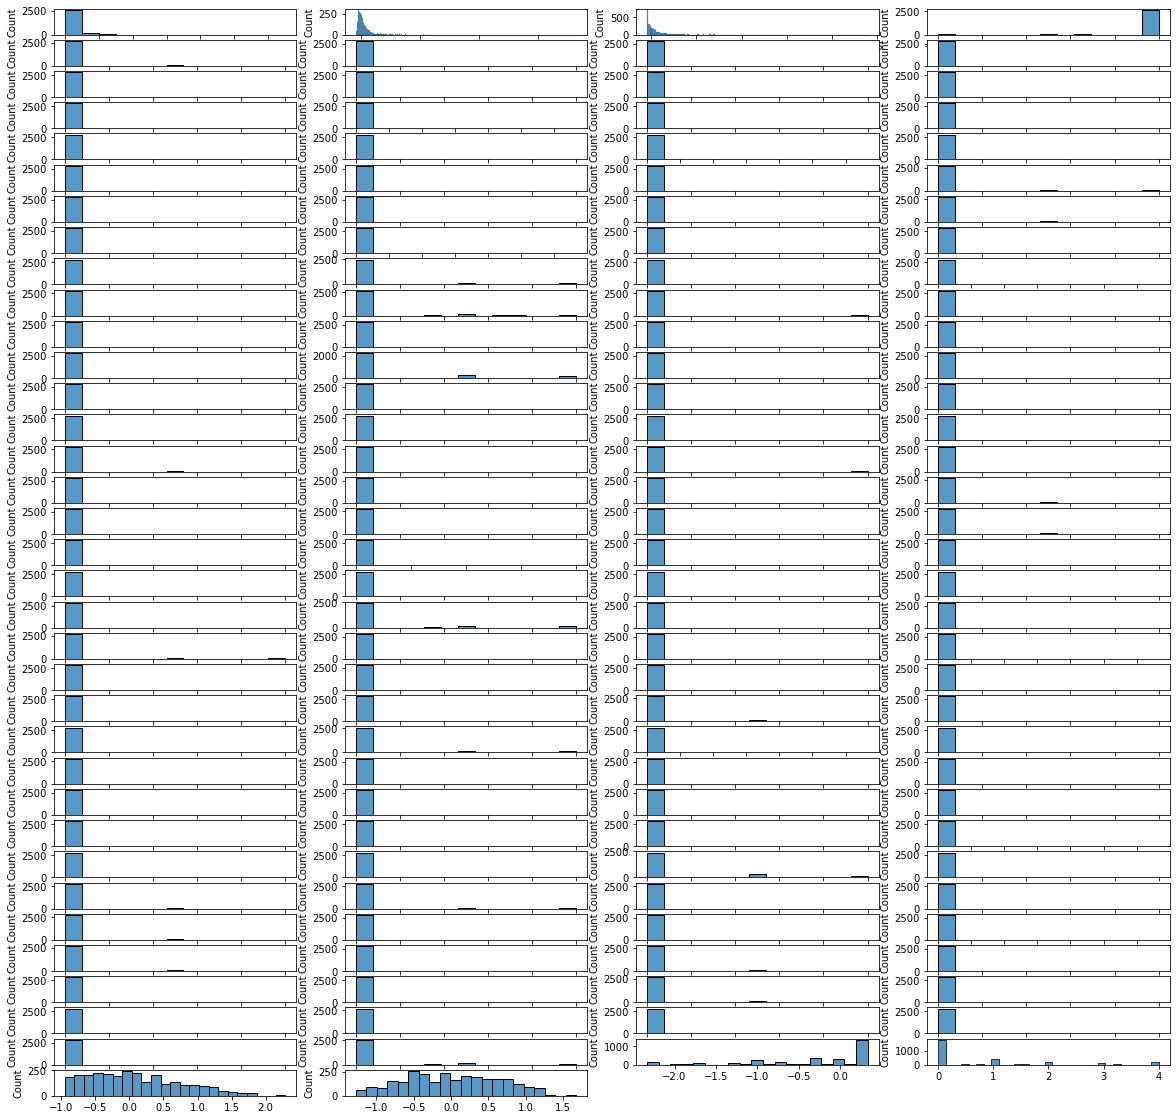

In [23]:
fig = plt.figure(figsize=(20,20))
for i in range(x_scale.shape[1]):
    ax = fig.add_subplot(int((x_scale.shape[1]/4)+1), 4, i+1)
    sns.histplot(x_scale[:,i], ax = ax)

plt.show()

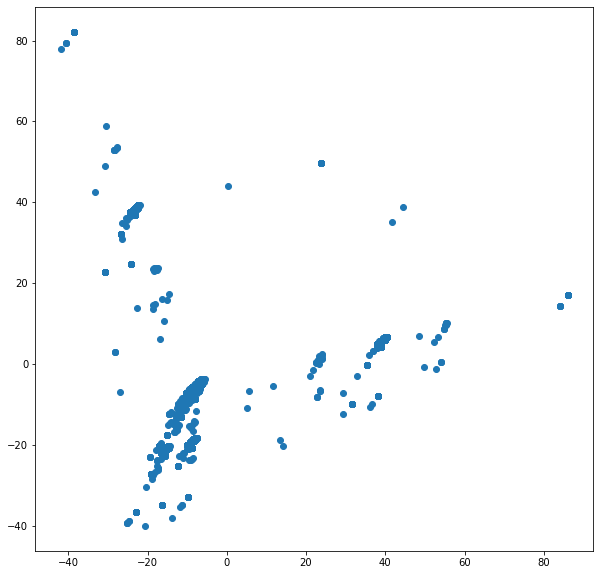

In [24]:
x_proj = pca.transform(x_scale)
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x_proj[:,0],x_proj[:,1])
plt.show()

In [25]:
from sklearn.manifold import Isomap
iso = Isomap()
from sklearn.manifold import MDS
mds = MDS()
from sklearn.manifold import TSNE
tsne = TSNE()

x_proj2 = mds.fit_transform(x_scale)
x_proj3 = tsne.fit_transform(x_scale)
#x_proj4 = iso.fit_transform(x_scale)

E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [26]:
from sklearn import cluster, metrics

Text(0.55, 0.4, 'Best silhouette : 0.45, Optimal Clus : 49')

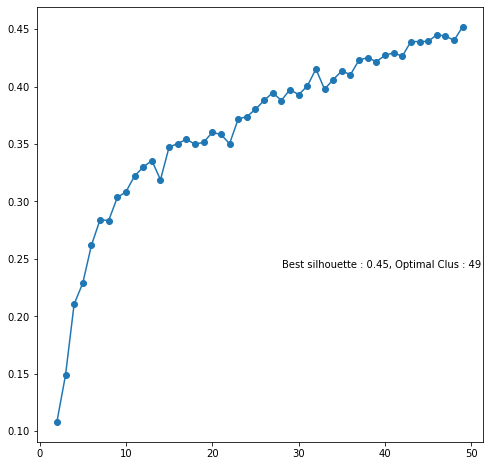

In [27]:
silhouette = []
for i in range(2,50):
    clus = cluster.KMeans(n_clusters = i)
    clus.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, clus.labels_)
    silhouette.append(sil)
max_sil = max(silhouette)
index = (silhouette.index(max_sil) +2)
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(range(2,50), silhouette, marker ='o')
ax.text(0.55,0.4,'Best silhouette : {:.2f}, Optimal Clus : {}'.format(max_sil, index), transform = ax.transAxes)

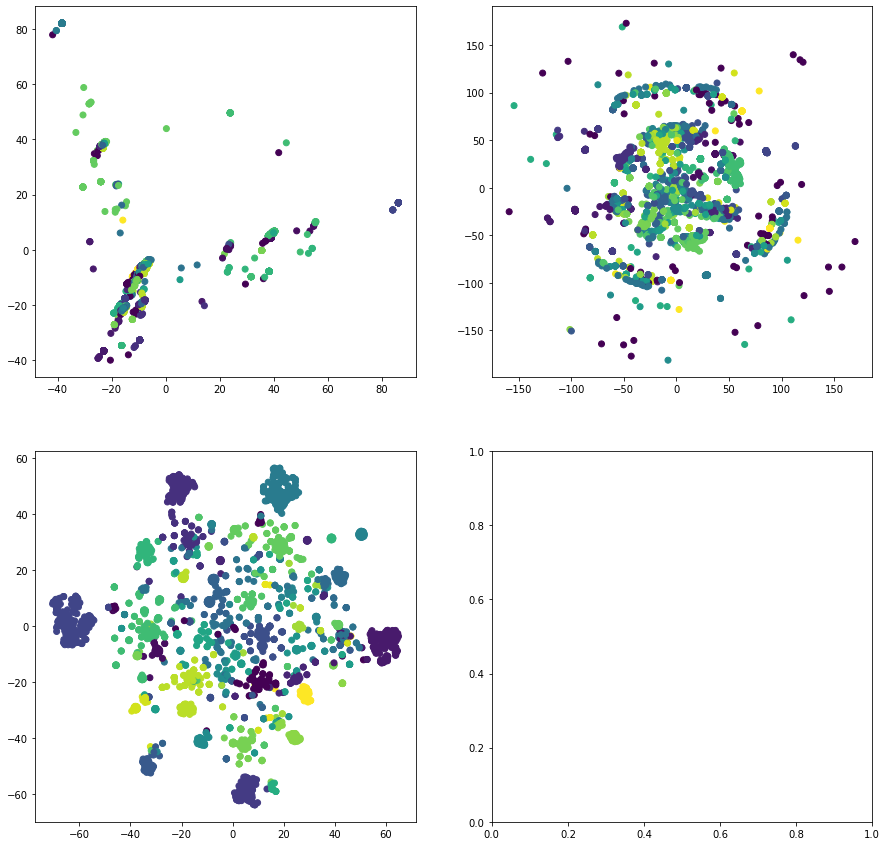

In [28]:
clus = cluster.KMeans(n_clusters = 30)
clus.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=clus.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=clus.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=clus.labels_)

plt.show()

Text(0.55, 0.4, 'Best silhouette : 0.55, Optimal Eps : 4.5')

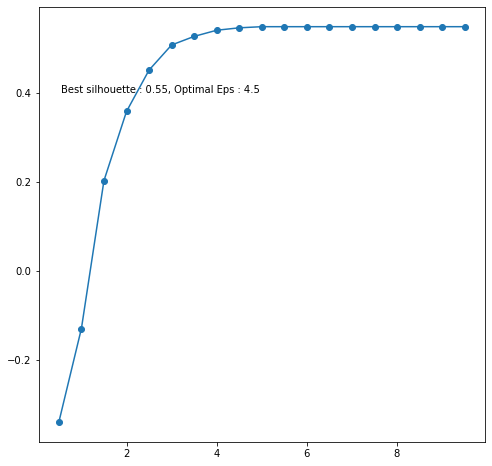

In [29]:
silhouette = []
eps_range = list(np.arange(0.5,10,0.5))
for i in eps_range:
    dbscan = cluster.DBSCAN(eps = i)
    dbscan.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, dbscan.labels_)
    silhouette.append(sil)
    
max_sil = max(silhouette)
index = (silhouette.index(max_sil))
fig,ax = plt.subplots(figsize = (8,8))
ax.plot(np.arange(0.5,10,0.5), silhouette, marker ='o')
ax.text(0.55,0.4,'Best silhouette : {:.2f}, Optimal Eps : {}'.format(max_sil, round(index/2,2), transform = ax.transAxes))

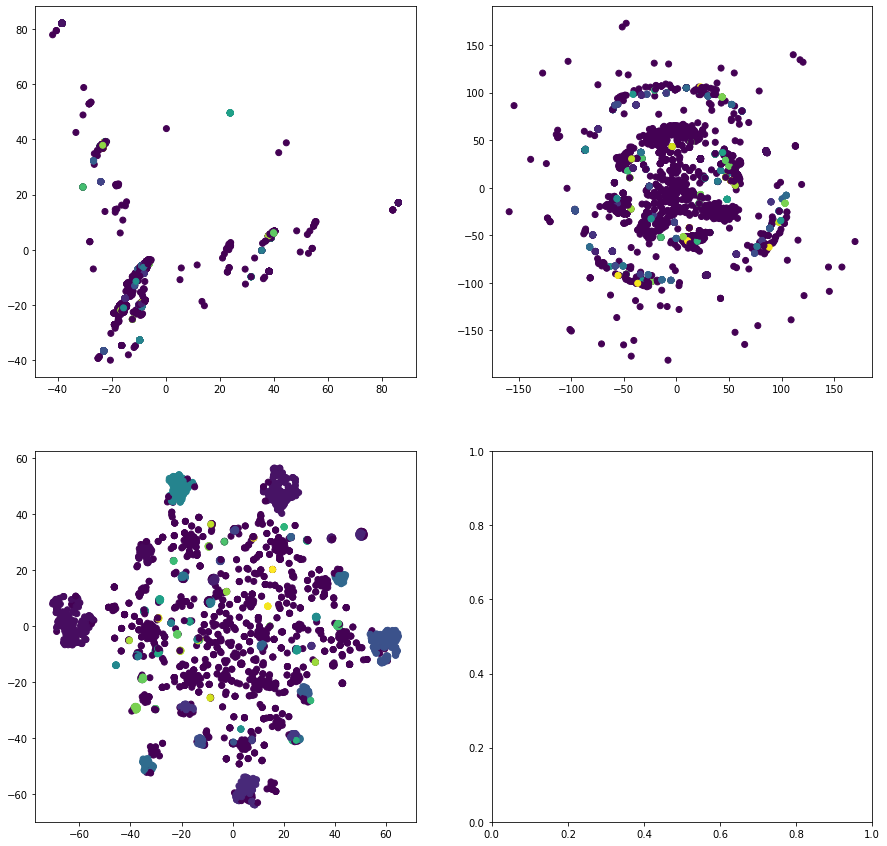

In [30]:


dbscan = cluster.DBSCAN(eps = 1.6)

dbscan.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=dbscan.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=dbscan.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=dbscan.labels_)

plt.show()

In [31]:
md_df['clus_label'] = clus.labels_
clus_sil = round(metrics.silhouette_score(x_scale, clus.labels_),2)
md_df['dbscan_label'] = dbscan.labels_
dbscan_sil = round(metrics.silhouette_score(x_scale, dbscan.labels_),2)
print('KMeans have found {} clusters with a silhouette score of : {}'.format(len(md_df['clus_label'].unique()), clus_sil))
print('BDscan have found {} clusters with a silhouette score of : {}'.format(len(md_df['dbscan_label'].unique()), dbscan_sil))

KMeans have found 30 clusters with a silhouette score of : 0.39
BDscan have found 61 clusters with a silhouette score of : 0.24


In [62]:
n_order_m = md_df.describe().iloc[1,0]
payment_m = md_df.describe().iloc[1,1]
rev_m_m = md_df.describe().iloc[1,-6]

In [58]:
md_df.describe()

n_order  payment_mean  payment_std  (6.621, 505.438]  \
count  2808.000000   2808.000000  2808.000000       2808.000000   
mean      2.111467    147.191666    65.919883         96.948020   
std       0.494397    152.453940   112.698087         13.675157   
min       2.000000     15.620000     0.000000          0.000000   
25%       2.000000     71.478750     8.987327        100.000000   
50%       2.000000    110.155000    32.682475        100.000000   
75%       2.000000    172.345000    76.314499        100.000000   
max      15.000000   3785.815000  1646.887049        100.000000   

       (505.438, 999.316]  (999.316, 1493.194]  (1493.194, 1987.072]  \
count         2808.000000          2808.000000           2808.000000   
mean             2.291061             0.565050              0.089031   
std             11.500087             5.870143              2.108370   
min              0.000000             0.000000              0.000000   
25%              0.000000             0.000000              0.000000   
50%              0.000000             0.000000              0.000000   
75%              0.000000             0.000000              0.000000   
max            100.000000           100.000000             50.000000   

       (1987.072, 2480.95]  (2480.95, 2974.828]  (4456.462, 4950.34]  ...  \
count          2808.000000          2808.000000          2808.000000  ...   
mean              0.053419             0.035613             0.017806  ...   
std               2.109573             1.334164             0.943564  ...   
min               0.000000             0.000000             0.000000  ...   
25%               0.000000             0.000000             0.000000  ...   
50%               0.000000             0.000000             0.000000  ...   
75%               0.000000             0.000000             0.000000  ...   
max             100.000000            50.000000            50.000000  ...   

       {'telefonia_fixa'}  {'utilidades_domesticas', 'market_place'}  \
count         2808.000000                                2808.000000   
mean             0.189932                                   0.017806   
std              3.044006                                   0.943564   
min              0.000000                                   0.000000   
25%              0.000000                                   0.000000   
50%              0.000000                                   0.000000   
75%              0.000000                                   0.000000   
max             50.000000                                  50.000000   

       {'utilidades_domesticas', 'moveis_decoracao'}  \
count                                    2808.000000   
mean                                        0.053419   
std                                         1.633719   
min                                         0.000000   
25%                                         0.000000   
50%                                         0.000000   
75%                                         0.000000   
max                                        50.000000   

       {'utilidades_domesticas'}     rev_mean      rev_std  \
count                2808.000000  2808.000000  2808.000000   
mean                    5.467325     4.161333     0.493856   
std                    18.047675     1.104741     0.819745   
min                     0.000000     1.000000     0.000000   
25%                     0.000000     3.500000     0.000000   
50%                     0.000000     4.500000     0.000000   
75%                     0.000000     5.000000     0.707107   
max                   100.000000     5.000000     2.828427   

       days_since_last_order          age   clus_label  dbscan_label  
count            2808.000000  2808.000000  2808.000000   2808.000000  
mean             1772.733262  1860.641382    13.008547      7.218661  
std               144.534701   146.743258     8.149341     13.575342  
min              1548.000000  1557.000000     0.000000     -1.00000

In [104]:
temp = pd.DataFrame(md_df.groupby('clus_label').mean())
temp = temp.iloc[:,10:134]
temp2 = temp.T


for i in range(temp2.shape[1]):    
    val = list(round(temp2.iloc[:,i].nlargest(3),2))
    cat = list(temp2.iloc[:,i].nlargest(3).index)
    cat_top3 = dict(zip(cat, val))
    top1=[]
    top2=[]
    top3=[]
    for y in cat_top3:
        cat_list = []
        cat_list.append(str(y)+':'+str(cat_top3[y]))
        #top1.append(cat_list[0])
        #top2.append(cat_list[1])
        #top3.append(cat_list[2])
print(cat_list)        



["{'agro_industria_e_comercio'}:0.0"]


In [ ]:
#need to be a dict {Top1 : ['cat:perc', 'cat:perc'], Top2 : ['cat:perc']...}

In [102]:
liste = []
for i in cat_top3:
    liste.append(str(i)+':'+str(cat_top3[i]))
liste[0]


"{'relogios_presentes'}:99.62"

In [64]:
expl_df = pd.DataFrame()
expl_df['freq'] = md_df.groupby('clus_label').n_order.count()
expl_df['freq'] = round((expl_df['freq']/md_df.shape[0])*100,2)
expl_df['n_order_mean'] = md_df.groupby('clus_label').n_order.agg('mean')
expl_df['n_order_ratio'] = round(expl_df['n_order_mean']/n_order_m,2)
expl_df['n_order_max'] = md_df.groupby('clus_label').n_order.agg('max')
expl_df['payment_m_m'] = md_df.groupby('clus_label').payment_mean.agg('mean')
expl_df['payment_m_r'] = round(expl_df['payment_m_m']/payment_m,2)
expl_df['rev_m_m'] = md_df.groupby('clus_label').rev_mean.agg('mean')
expl_df['rev_ratio'] =round(expl_df['rev_m_m']/rev_m_m,2)

expl_df

freq  n_order_mean  n_order_ratio  n_order_max  payment_m_m  \
clus_label                                                                
0           2.67      2.053333           0.97            3   574.634689   
1           1.42      2.400000           1.14            5   109.929342   
2           5.31      2.114094           1.00            4   120.690190   
3           2.49      2.157143           1.02            5   148.463995   
4           6.20      2.034483           0.96            4   153.698103   
5           3.63      2.029412           0.96            4   151.012525   
6           7.41      2.076923           0.98            7   139.279283   
7           4.91      2.115942           1.00            6   122.023931   
8           2.03      2.192982           1.04            3    88.539064   
9           4.31      2.024793           0.96            3   122.338664   
10          2.74      2.194805           1.04            4    90.299903   
11          4.56      2.273438           1.08            6   158.049025   
12          5.88      2.072727           0.98            4   142.661131   
13          3.70      2.038462           0.97            3   134.328333   
14          2.81      2.088608           0.99            5   165.041861   
15          2.07      2.017241           0.96            3   108.824052   
16          2.49      2.114286           1.00            7   171.388218   
17          2.49      2.085714           0.99            3   134.952048   
18          0.68      2.210526           1.05            3   524.122368   
19          3.24      2.197802           1.04            7   134.868851   
20          5.45      2.143791           1.02            9   130.760717   
21          2.46      2.043478           0.97            3    96.413720   
22          4.38      2.284553           1.08           15   122.905630   
23          3.74      2.085714           0.99            3   107.466524   
24          2.10      2.084746           0.99            4   114.504816   
25          0.85      2.125000           1.01            3   158.161667   
26          6.30      2.045198           0.97            4   132.876629   
27          1.32      2.054054           0.97            3   124.524730   
28          0.46      2.076923           0.98            3   115.894103   
29          1.89      2.226415           1.05            5   163.682377   

            payment_m_r   rev_m_m  rev_ratio  
clus_label                                    
0                  3.90  4.060000       0.98  
1                  0.75  4.101667       0.99  
2                  0.82  4.241051       1.02  
3                  1.01  4.214286       1.01  
4                  1.04  3.951149       0.95  
5                  1.03  3.754902       0.90  
6                  0.95  3.891026       0.94  
7                  0.83  4.293478       1.03  
8                  0.60  3.956628       0.95  
9                  0.83  4.216942       1.01  
10                 0.61  4.028139       0.97  
11                 1.07  4.252995       1.02  
12                 0.97  4.226263       1.02  
13                 0.91  4.316506       1.04  
14                 1.12  4.236287       1.02  
15                 0.74  4.264368       1.02  
16                 1.16  4.321429       1.04  
17                 0.92  4.447619       1.07  
18                 3.56  4.135965       0.99  
19                 0.92  3.960989       0.95  
20                 0.89  4.211511       1.01  
21                 0.66  3.934783       0.95  
22                 0.84  4.382791       1.05  
23                 0.73  4.210317       1.01  
24                 0.78  4.285311       1.03  
25                 1.07  4.277778       1.03  
26                 0.90  4.338512       1.04  
27                 0.85  4.250000       1.02  
28                 0.79  4.282051       1.03  
29                 1.11  4.007547       0.96